# About

Create a function that can be used in the 2nd stage regression to perform a time series cross validation. 
- Using an expanding window cross validation


The 2nd stage regression predicts the medical outcomes using the predicted PM2.5 (and separately with the actual pm2.5), as well as the same fixed effects from the first stage regression. 

In [1]:
# optional. I'm getting annoying warnings that I just want to ignore:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# basics
import pandas as pd 
import numpy as np
import os 
import re
from datetime import datetime
from tqdm.notebook import tqdm
tqdm.pandas()
import requests
import urllib
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import TimeSeriesSplit

# plotting
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import plotly.express as px
import seaborn as sns

# modeling
from patsy import dmatrices
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.sandbox.regression.gmm import IV2SLS
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

In [2]:
# keep this as false unless you want to save out the fitted model objects and results 
save_results = False

Select your predictor, lead, lag times, and lag style here.

In [3]:
predictor = 'Izmy_v3_normed_D_and_TPY'
lead_time = '9'
lag_time = '3'
lag_style = 'fwd'

# define lead time for IV: 'last_month', 'r6', 'r9', 'r12'
IV_lead = "r" + str(lead_time)
HO_lag = lag_style + str(lag_time)

if IV_lead:
    IV_lead_input = "_" + IV_lead 
else:
    # don't add underscore if empty string
    IV_lead_input = IV_lead

# define lag time for Health Outcome: '', 'fwd3', 'cent3', 'fwd6', 'cent6', 'fwd12', 'cent12'
if HO_lag:
    HO_lag_input = "_" + HO_lag 
else:
    # don't add underscore if empty string
    HO_lag_input = HO_lag

# IV options: 1 month, 6 months, 9 months, 12 months
IV_window_col = [f'pm25{IV_lead_input}']

# health outcome options (fwd or cent): 1 month, 3 months, 6 months, 12 months
health_outcome_window_col = [f'y_injuries{HO_lag_input}']

filter_cols = IV_window_col + health_outcome_window_col # columns to filter out at the beginning and end of df, before modeling

target_name_s1 = f'pm25{IV_lead_input}'
predictor_name_s1 = f'{predictor}{IV_lead_input}'

print(f"Stage 1\nTarget Name (target_name_s1) = {target_name_s1}\nPredictor Name (predictor_name_s1) = {predictor_name_s1}")

print(f"\nStage 2\nHealth Outcome Lag Input (HO_lag_input) = {HO_lag_input}")

Stage 1
Target Name (target_name_s1) = pm25_r9
Predictor Name (predictor_name_s1) = Izmy_v3_normed_D_and_TPY_r9

Stage 2
Health Outcome Lag Input (HO_lag_input) = _fwd3


# Set Path

Add a new elif section for your path if you want

In [4]:
# local or gdrive
path_source = 'local'

if path_source == 'gdrive':
  from google.colab import drive
  drive.mount('/content/gdrive')
  data_path = '/content/gdrive/MyDrive/Classes/W210_capstone/W210_Capstone/Data'
  fitted_models_path = '/content/gdrive/MyDrive/Classes/W210_capstone/W210_Capstone/fitted_models/2022-10-23'
  
elif path_source == 'local':
  # data_path = '/Users/tj/trevorj@berkeley.edu - Google Drive/My Drive/Classes/W210_capstone/W210_Capstone/Data'
  # fitted_models_path = '/Users/tj/trevorj@berkeley.edu - Google Drive/My Drive/Classes/W210_capstone/W210_Capstone/fitted_models/2022-10-23'

  data_path = 'G:\\.shortcut-targets-by-id\\11wLy1WKwOTcthBs1rpfEzkqax2BZG-6E\\W210_Capstone\\Data'
  fitted_models_path = 'G:\\.shortcut-targets-by-id\\11wLy1WKwOTcthBs1rpfEzkqax2BZG-6E\W210_Capstone\\fitted_models\\2022-11-19\\XGB'

elif path_source == 'work':
  data_path = '/Users/trevorjohnson/trevorj@berkeley.edu - Google Drive/My Drive/Classes/W210_capstone/W210_Capstone/Data'
  fitted_models_path = '/Users/trevorjohnson/trevorj@berkeley.edu - Google Drive/My Drive/Classes/W210_capstone/W210_Capstone/fitted_models/2022-10-23'

In [5]:
# read in our modeling data
df = pd.read_csv(os.path.join(data_path, 'modeling_data/modeling_data_joined_11-22-top15_4tpy_ds_wind_ratios.csv'))

# read in cornelia's healthcare data
df1 = pd.read_csv(os.path.join(data_path, 'medical/hematopoietic_cancers.csv')).iloc[:,1:]
df2 = pd.read_csv(os.path.join(data_path, 'medical/pediatric_vasculitis.csv')).iloc[:,1:]
df3 = pd.read_csv(os.path.join(data_path, 'medical/type_1_diabetes.csv')).iloc[:,1:]
df4 = pd.read_csv(os.path.join(data_path, 'medical/resp_cardio.csv')).iloc[:,1:]
df5 = pd.read_csv(os.path.join(data_path, 'medical/injuries_accidents.csv')).iloc[:,1:]

In [6]:
temp = df[(df.year <= 2017) & (df.year >= 2002)].isna().sum()
temp[temp > 0]

pm25_last_month      24
pm25_r6             146
pm25_r9             224
pm25_r12            302
pm25_r24           1065
pm25_slope6         146
pm25_slope9         224
pm25_slope12        302
pm25_slope24       1065
pm25_lag_12mo       302
dtype: int64

In [7]:
temp = df[(df.year <= 2017)].isna().sum()
temp[temp > 0]

pm25_last_month                       1387
pm25_r6                               8322
pm25_r9                              12483
pm25_r12                             16644
pm25_r24                             33288
pm25_slope6                           8322
pm25_slope9                          12483
pm25_slope12                         16644
pm25_slope24                         33288
pm25_lag_12mo                        16644
central_wind_alignment_180_high      15881
avg_count_ps_within_5km              15881
avg_elevation_diff_m                 15881
avg_wspd_ratio_ps_sch                15881
avg_wspd_ratio_sch_ps                15881
avg_school_wspd                      15881
avg_ps_wspd                          15881
new_alignment_90_high                15881
ps_pm25_tpy_top_20                   15881
school_to_ps_geod_dist_m_top_20      15881
avg_wspd_top_15                      15881
Izmy_v1_unnormed                     15881
Izmy_v2_nodist_unnormed              15881
Izmy_v3_nor

In [8]:
temp = df[(df.year >= 2002)].isna().sum()
temp[temp > 0]

pm25_last_month                         24
pm25_r6                                146
pm25_r9                                224
pm25_r12                               302
pm25_r24                              1065
pm25_slope6                            146
pm25_slope9                            224
pm25_slope12                           302
pm25_slope24                          1065
pm25_lag_12mo                          302
central_wind_alignment_180_high      16266
avg_count_ps_within_5km              16266
avg_elevation_diff_m                 16266
avg_wspd_ratio_ps_sch                16266
avg_wspd_ratio_sch_ps                16266
avg_school_wspd                      16266
avg_ps_wspd                          16266
new_alignment_90_high                16266
ps_pm25_tpy_top_20                   16266
school_to_ps_geod_dist_m_top_20      16266
avg_wspd_top_15                      16266
Izmy_v1_unnormed                     16266
Izmy_v2_nodist_unnormed              16266
Izmy_v3_nor

# Data Clean

In [9]:
df.columns.tolist()

['Unnamed: 0.1',
 'Unnamed: 0',
 'year_month',
 'school_zip',
 'school_county_v2',
 'school_region_name',
 'pm25',
 'school_elevation_m',
 'ps_elevation_m',
 'population_0_4',
 'population_0_4_male',
 'population_0_4_female',
 'population_5_9',
 'population_5_9_male',
 'population_5_9_female',
 'population_10_14',
 'population_10_14_male',
 'population_10_14_female',
 'population_15_19',
 'population_15_19_male',
 'population_15_19_female',
 'total_pop_under19',
 'pop_under19_male',
 'pop_under19_female',
 'total_population',
 'total_population_male',
 'total_population_female',
 'point_source_pm25_tpy',
 'dist_school_to_ps_m',
 'angle_to_school',
 'ps_wspd_merge',
 'school_wdir_wrt_0n',
 'ps_wdir_wrt_0n',
 'school_wind_alignment',
 'ps_wind_alignment',
 'avg_wind_alignment',
 'avg_wind_alignment_cosine',
 'nearby_point_source_count',
 'school_wspd',
 'ca_agi_per_returns',
 'total_tax_liability',
 'tax_liability_per_capita',
 'school_temperature',
 'ps_temperature',
 'school_count',
 '

We used to make these, but Matt added them in as columns the right way:

```
# make missing columns that will be added by Matt later
df['avg_temp'] = ((df['school_temperature'] + df['ps_temperature']) / 2)
df['diff_temp_s_ps'] = (df['school_temperature'] - df['ps_temperature'])
```

### Make Rolling Columns for IVs

In [11]:
def roll_selected_cols(df, cols_to_roll:list = ['Izmy_v1_unnormed'\
    ,'Izmy_v2_nodist_unnormed' \
    ,'Izmy_v3_normed_D_and_TPY' \
    ,'Izmy_v4_nodist_normed_TPY' \
    ,'Izmy_v5_all_normed'
    ,'Izmy_v6_unnormed_no_wspd'
    ,'Izmy_v7_all_normed_no_wspd'
    ,'Izmy_v8_normed_D_and_TPY_no_wspd'
    ,'new_alignment_90_high']
    ,rolling_periods:list = [1, 6, 9, 12]):

    """Generates rolling averages for the input variables over the input time periods.
    Inputs: df (pd dataframe): contains the data on a y-m level
            cols_to_roll (list): list of columns to generate rolling avgs--must be in df
            rolling_periods (list): list of time windows (in months) to roll over
            
    Outputs: df: Pandas dataframe containing the new columns
             all_cols: list of list containing the new columns, separated by input type"""
    
    df_int = df.copy().sort_values(['school_zip', 'year_month'])
    
    all_cols_int = []

    # Roll each variable
    for col_index in range(len(cols_to_roll)):
        new_cols = []

        col_to_roll = cols_to_roll[col_index]
        rolling_periods = [1, 6, 9, 12]

        for period in rolling_periods:
            df_int[f'{col_to_roll}_r{period}'] = df_int.groupby('school_zip')[col_to_roll]\
                .apply(lambda x: x.rolling(window=period, min_periods=period, closed='left').mean())
            
            new_cols.append(col_to_roll + "_r" + str(period))

        all_cols_int.append([col_to_roll] + new_cols)
        
    return df_int, all_cols_int

In [12]:
cols_to_roll = ['Izmy_v3_normed_D_and_TPY' \
    ,'Izmy_v4_nodist_normed_TPY' \
    ,'Izmy_v5_all_normed_but_wspd_ratio'
    ,'avg_temp'
    ,'diff_temp_s_ps']
    
rolling_periods = [9]

df, all_cols = roll_selected_cols(df=df, cols_to_roll=cols_to_roll, rolling_periods=rolling_periods)

In [13]:
# rename the last month column just to be consistent and safe
df.rename(columns={'pm25_last_month': 'pm25_r1'}, inplace=True)

In [14]:
temp = df[(df.year <= 2017) & (df.year >= 2002)].isna().sum()
temp[temp > 0]

pm25_r1                                  24
pm25_r6                                 146
pm25_r9                                 224
pm25_r12                                302
pm25_r24                               1065
                                       ... 
school_to_ps_geod_dist_m_top_20_r12     302
avg_wspd_top_20_r1                       24
avg_wspd_top_20_r6                      146
avg_wspd_top_20_r9                      224
avg_wspd_top_20_r12                     302
Length: 86, dtype: int64

### Clean and Merge in Health Outcome Data

#### Fill in nulls conditionally on merged datasets

- the problem: for each health outcome, we want to fill in the nulls for a zipcode with 0's only if that row occurred after the first non-zero/not null visit in that zipcode for that health outcome. Keep them as nulls otherwise.

- So basically a zipcode will keep the nulls if they're on a date before the first visit seen for that health outcome, nulls will become 0 after the first visit seen for that health outcome.

In [15]:
def filter_nans(df, visits_cols = ['visits_hematopoietic_cancers', 'visits_injuries_accidents',
       'visits_type_1_diabetes', 'visits_pediatric_vasculitis',
       'visits_resp_cardio']):
    """Function to generate columns in place that replace NaNs with 0's only if that 
    row occurred after the first non-zero/not null visit in that zipcode for the specific
    health outcome. Keeps them as nulls otherwise.

    Args:
        df (DataFrame): Input dataframe
        visits_cols (list, optional): list of columns to selectively filter NaNs
    Returns:
        DataFrame with columns replaced with their NaN-filtered versions
    """

    def get_rowIndex(row):
        """Function intended for applying across df rows

        Args:
            row (int): row

        Returns:
            int: index of row
        """
      
        return row.name

    def compare_and_replace(orig_visits, dataset_row_idx, school_zip):
        """Function intended for applying across df rows
         Selectively replaces NaNs with 0's
        Args:
            orig_visits: original column that needs to be filtered
            dataset_row_idx: column with row indices for the entire df
            school_zip: column with school zips

        Returns:
            float or NaN
        """
        
        # school zip + zip idx
        first_val_row_idx = dict_row_idx[school_zip]
        zip_idx = dict_zip_idx[school_zip]
        max_idx = dict_max_zipindex_per_zip[school_zip]
        difference = max_idx - zip_idx + 1

        # check the school zip first
        if dataset_row_idx < first_val_row_idx:
            orig_visits = orig_visits
        elif (dataset_row_idx >= first_val_row_idx) and (dataset_row_idx <=  first_val_row_idx + difference):
            if pd.isnull(orig_visits):
                orig_visits = 0
            else:
                orig_visits = orig_visits
        return orig_visits
        
    # group df by school_zip, year_month
    df_grouped_schools = df.groupby(['school_zip', 'year_month']).tail(1)

    #df_grouped_schools['points_rank'] = df.groupby(['team'])['points'].rank('dense', ascending=False)
    unique_school_zips = list(df_grouped_schools['school_zip'].unique())

    # generate overall row index
    df_grouped_schools['rowIndex'] = df_grouped_schools.apply(get_rowIndex, axis=1)

    # generate row indices that rest per school zip
    df_grouped_schools['zipIndex'] = df_grouped_schools.groupby(['school_zip'])['year_month'].rank('first', ascending=True).astype(int)
    df_grouped_schools['zipIndex'] = df_grouped_schools['zipIndex'] - 1

    # generate dictionary that gets max index per school zip
    dict_max_zipindex_per_zip = {}
    for i in unique_school_zips:
        dict_max_zipindex_per_zip[i] = df_grouped_schools[df_grouped_schools['school_zip']==i]['zipIndex'].max()

    for i in visits_cols:
        dict_zip_idx = {}
        dict_row_idx = {}
        for j in unique_school_zips:
            temp = df_grouped_schools[df_grouped_schools['school_zip']==j]
            #display(temp)
            #temp['rowIndex'] = temp.apply(get_rowIndex, axis=1)
            visits_series = pd.Series(temp[i]) # one school zip, filtered to 1 health outcome
            #display(visits_series)
            bool_not_null = visits_series.notnull()
            all_indices_not_null = np.where(bool_not_null)[0]

            # save index of the first non-NaN value within the zipcode indices
            # if everything every value for zip is NaN, set value to # of records in df
            try:
                groupby_index = all_indices_not_null[0]
            except IndexError:
                groupby_index = df_grouped_schools.shape[0]
            dict_zip_idx[j] = groupby_index
            
            # save index of the row from whole dataset; set valye to # of records in df if not
            try:
                row_idx = temp.loc[temp['zipIndex'] == groupby_index, 'rowIndex'].values[0]
            except IndexError:
                row_idx = df_grouped_schools.shape[0]
            dict_row_idx[j] = row_idx
        
        df_grouped_schools[i] = df_grouped_schools.apply(lambda row: compare_and_replace(row[i], row['rowIndex'], row['school_zip']), axis=1)

    # drop rowIndex and zipIndex cols
    df_grouped_schools.drop(columns=['rowIndex', 'zipIndex'], inplace=True)

    return df_grouped_schools

In [16]:
# Michelle's dummy_df for testing
dummy_df = pd.DataFrame()
dummy_df['school_zip'] = [1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3]

dummy_df['year_month'] = ['2000-01-01', '2000-02-01', '2000-03-01', '2000-04-01', 
                            '2000-01-01', '2000-02-01', '2000-03-01', '2000-04-01',
                            '2000-01-01', '2000-02-01', '2000-03-01', '2000-04-01','2000-05-01', '2000-06-01', '2000-07-01', '2000-08-01']
dummy_df['visits_hematopoietic_cancers'] = [None, None, 1, None, 
                                            None, None, None, None, 
                                            None, None, None, 1, None, None, 1, 1]
dummy_df['visits_injuries_accidents'] = [1, None, 1, None, 
                                        None, None, 1, None, 
                                        1, None, None, None, 1, 1, 1, 1]

display(dummy_df)

,school_zip,year_month,visits_hematopoietic_cancers,visits_injuries_accidents
0,1,2000-01-01,NaN,1.0
1,1,2000-02-01,NaN,NaN
2,1,2000-03-01,1.0,1.0
3,1,2000-04-01,NaN,NaN
4,2,2000-01-01,NaN,NaN
5,2,2000-02-01,NaN,NaN
6,2,2000-03-01,NaN,1.0
7,2,2000-04-01,NaN,NaN
8,3,2000-01-01,NaN,1.0
9,3,2000-02-01,NaN,NaN


In [17]:
dummy_df_2 = filter_nans(dummy_df, ['visits_hematopoietic_cancers', 'visits_injuries_accidents'])
display(dummy_df_2)

,school_zip,year_month,visits_hematopoietic_cancers,visits_injuries_accidents
0,1,2000-01-01,NaN,1.0
1,1,2000-02-01,NaN,0.0
2,1,2000-03-01,1.0,1.0
3,1,2000-04-01,0.0,0.0
4,2,2000-01-01,NaN,NaN
5,2,2000-02-01,NaN,NaN
6,2,2000-03-01,NaN,1.0
7,2,2000-04-01,NaN,0.0
8,3,2000-01-01,NaN,1.0
9,3,2000-02-01,NaN,0.0


In [18]:
# med data:

# get all distinct patzip_year_month
all_pats = df1['patzip_year_month'].to_list() + \
  df2['patzip_year_month'].to_list() + \
  df3['patzip_year_month'].to_list() + \
  df4['patzip_year_month'].to_list() + \
  df5['patzip_year_month'].to_list() 
all_pats = list(set(all_pats))
df_med = pd.DataFrame({'patzip_year_month': all_pats})

# rename columns more intuitively
df1 = df1.rename(columns={'number_of_visits': 'number_of_visits_hem_cancers'})
df2 = df2.rename(columns={'number_of_visits': 'number_of_visits_vasc'})
df3 = df3.rename(columns={'number_of_visits': 'number_of_visits_diab'})
df4 = df4.rename(columns={'number_of_visits': 'number_of_visits_resp_cardio'})
df5 = df5.rename(columns={'number_of_visits': 'number_of_visits_injuries'})

# now join all the diagnoses on this dataset
df_med = df_med\
  .merge(df1, on='patzip_year_month', how='left')\
  .merge(df2, on='patzip_year_month', how='left')\
  .merge(df3, on='patzip_year_month', how='left')\
  .merge(df4, on='patzip_year_month', how='left')\
  .merge(df5, on='patzip_year_month', how='left')

# join data
if isinstance(df.year_month[0], str):
  # if year month is still a string, convert it to datetime
  # don't try if already converted
    df['year_month'] = df['year_month'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))

df['zip_year_month'] = df['school_zip'].astype(str) + '-' +\
  df['year_month'].dt.year.astype(str) + '-' +\
  df['year_month'].dt.month.astype(str)

df = pd.merge(df, df_med, left_on='zip_year_month', right_on='patzip_year_month', how='left')
df = df.drop(columns = 'Unnamed: 0')

# for missing med data, assume there were 0 cases:
med_vars = ['hematopoietic_cancers', 'number_of_visits_hem_cancers', 
  'pediatric_vasculitis', 'number_of_visits_vasc', 
  'type_1_diabetes', 'number_of_visits_diab',
  'resp_cardio', 'number_of_visits_resp_cardio',
  'injuries_accidents', 'number_of_visits_injuries'
  ]


# for var in med_vars:
#   df[var] = df[var].fillna(0)


# df.sort_values(['school_zip', 'year_month'], inplace=True)

# Insert code here to populate na's for each HO with 0, only if there was a HO in this zipcode before
df = filter_nans(df, visits_cols = ['number_of_visits_hem_cancers', 'number_of_visits_vasc', 
'number_of_visits_diab', 'number_of_visits_resp_cardio', 'number_of_visits_injuries'])


# fixing month datatype
df['month'] = df['month'].astype(str)

# Create response variables, which is visits / population
df['y_hematopoietic'] = 1000 * df['number_of_visits_hem_cancers'] / df['total_pop_under19']
df['y_vasculitis'] = 1000 * df['number_of_visits_vasc'] / df['total_pop_under19']
df['y_diabetes'] = 1000 * df['number_of_visits_diab'] / df['total_pop_under19']
df['y_resp_cardio'] = 1000 * df['number_of_visits_resp_cardio'] / df['total_pop_under19']
df['y_injuries'] = 1000 * df['number_of_visits_injuries'] / df['total_pop_under19']

# Create an option for a logged version of the treatment var (log(1+x)). this makes it normally distributed 
df['pm25_log'] = np.log1p(df['pm25'])

# create year trend feature
df['year_trend'] = df['year'] - 1999

# create county_month
df['county_month'] = df.apply(lambda df: df['month'].rjust(2, '0') + '_' + df['school_county_v2'], axis=1)

# create year_month_county (in case we want to just direclty use this var for the interaction effects)
df['year_month_county'] = df.apply(lambda df: str(df['year']) + '_' + df['month'] + '_' + df['school_county_v2'], axis=1)

# no need to one hot encode anymore, b/c data is already encoded 



### Make Rolling HO Sum Columns

In [19]:
# train/test split 
# keep 2018 as the held out test set 
df_test_final = df[df.year == 2018]
df = df[df.year != 2018]

In [20]:
# get rolling n month sum

def create_rolling_sum(df, var_name:str = 'number_of_visits_hem_cancers', num_months=3, center_arg:bool = False):
  """
    Creates rolling sums for the number of visits for a given health outcome. 
    Overwrite your dataframe with the output.
    Function saves the result as a column into the dataframe with subscripts 
    - '{var_name}_fwd{number of months}' for forward sums
    - '{var_name}_cent{number of months}' for centered sums

    Function includes the current month as one of the months in num_months.

    Dataframe input MUST be sorted by ['school_zip', 'year_month'] ahead of time.

    `df = df.sort_values(['school_zip', 'year_month'])`

    Suggested: filter out tail end of dates so rolling averages are not filled with imputed values.

  Args:
      `df` (dataframe): dataframe having columns for 'school_zip', datetime 'year_month', and number of visits. Dataframe must be sorted by 
      `var_name` (str, optional): health outcome number of visits. Defaults to 'number_of_visits_hem_cancers'.
      `num_months` (int, optional): Number of months to take rolling sum over. Defaults to 3.
      `center_arg` (bool, optional): If this sum should be centered on current month. Defaults to False.

  Returns:
      `df_int`: returns dataframe with column added
  """
  df_int = df.copy().sort_values(['school_zip', 'year_month'])
  
  if center_arg:
    df_int[f'{var_name}_cent{num_months}'] = df_int.groupby('school_zip')[var_name]\
                                      .apply(lambda x:x.rolling(num_months, center=True).sum())
  else:
    df_int[f'{var_name}_fwd{num_months}'] = df_int.groupby('school_zip')[var_name]\
                                      .apply(lambda x:x.rolling(num_months).sum().shift(1-num_months))

  
  return df_int 

In [21]:
print(min(df.year))
print(max(df.year))

2000
2017


In [22]:
# quality checking the na filtering
df.sort_values(['school_zip', 'year_month'])[df.school_zip == 97635].tail(20)

,year_month,school_zip,school_county_v2,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_speed,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_r1,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,avg_count_ps_within_5km,avg_elevation_diff_m,avg_wspd_ratio_ps_sch,avg_wspd_ratio_sch_ps,avg_school_wspd,avg_ps_wspd,new_alignment_90_high,ps_pm25_tpy_top_20,school_to_ps_geod_dist_m_top_20,avg_wspd_top_20,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed_but_wspd_ratio,Izmy_v6_unnormed_no_wspd,Izmy_v7_all_normed_no_wspd,Izmy_v8_normed_D_and_TPY_no_wspd,avg_temp,diff_temp_s_ps,Izmy_v1_unnormed_r1,Izmy_v1_unnormed_r6,Izmy_v1_unnormed_r9,Izmy_v1_unnormed_r12,Izmy_v2_nodist_unnormed_r1,Izmy_v2_nodist_unnormed_r6,Izmy_v2_nodist_unnormed_r9,Izmy_v2_nodist_unnormed_r12,Izmy_v3_normed_D_and_TPY_r1,Izmy_v3_normed_D_and_TPY_r6,Izmy_v3_normed_D_and_TPY_r9,Izmy_v3_normed_D_and_TPY_r12,Izmy_v4_nodist_normed_TPY_r1,Izmy_v4_nodist_normed_TPY_r6,Izmy_v4_nodist_normed_TPY_r9,Izmy_v4_nodist_normed_TPY_r12,Izmy_v5_all_normed_but_wspd_ratio_r1,Izmy_v5_all_normed_but_wspd_ratio_r6,Izmy_v5_all_normed_but_wspd_ratio_r9,Izmy_v5_all_normed_but_wspd_ratio_r12,Izmy_v6_unnormed_no_wspd_r1,Izmy_v6_unnormed_no_wspd_r6,Izmy_v6_unnormed_no_wspd_r9,Izmy_v6_unnormed_no_wspd_r12,Izmy_v7_all_normed_no_wspd_r1,Izmy_v7_all_normed_no_wspd_r6,Izmy_v7_all_normed_no_wspd_r9,Izmy_v7_all_normed_no_wspd_r12,Izmy_v8_normed_D_and_TPY_no_wspd_r1,Izmy_v8_normed_D_and_TPY_no_wspd_r6,Izmy_v8_normed_D_and_TPY_no_wspd_r9,Izmy_v8_normed_D_and_TPY_no_wspd_r12,new_alignment_90_high_r1,new_alignment_90_high_r6,new_alignment

Make Rolling Columns for HO's

In [23]:
df = df.sort_values(['school_zip', 'year_month'])
starting_cols = list(df.columns)

num_visits_col_names = ['number_of_visits_hem_cancers', 
  'number_of_visits_vasc', 
  'number_of_visits_diab',
  'number_of_visits_resp_cardio',
  'number_of_visits_injuries'
  ]

y_col_names = ['y_hematopoietic', 
  'y_vasculitis', 
  'y_diabetes',
  'y_resp_cardio',
  'y_injuries'
  ]

# 3 months ---
n = 3 # specify number of months

for health_outcome_y_col, health_outcome_visits_col in zip(y_col_names, num_visits_col_names):
    # forward looking columns
    df = create_rolling_sum(df=df, var_name=health_outcome_visits_col, num_months=n, center_arg=False)
    df[f'{health_outcome_y_col}_fwd{n}'] = 1000 * df[f'{health_outcome_visits_col}_fwd{n}'] / df['total_pop_under19']

    # centered columns
    df = create_rolling_sum(df=df, var_name=health_outcome_visits_col, num_months=n, center_arg=True)
    df[f'{health_outcome_y_col}_cent{n}'] = 1000 * df[f'{health_outcome_visits_col}_cent{n}'] / df['total_pop_under19']


# print columns added
ending_cols = list(df.columns)
window_3months_columns = [c for c in ending_cols if c not in starting_cols]
print(f"\nColumns added for health outcomes using 3 month window:\n{window_3months_columns}")
starting_cols = list(df.columns)

# # 6 months ---
# n = 6 # specify number of months

# for health_outcome_y_col, health_outcome_visits_col in zip(y_col_names, num_visits_col_names):
#     # forward looking columns
#     df = create_rolling_sum(df=df, var_name=health_outcome_visits_col, num_months=n, center_arg=False)
#     df[f'{health_outcome_y_col}_fwd{n}'] = 1000 * df[f'{health_outcome_visits_col}_fwd{n}'] / df['total_pop_under19']

#     # centered columns
#     df = create_rolling_sum(df=df, var_name=health_outcome_visits_col, num_months=n, center_arg=True)
#     df[f'{health_outcome_y_col}_cent{n}'] = 1000 * df[f'{health_outcome_visits_col}_cent{n}'] / df['total_pop_under19']


# # print columns added
# ending_cols = list(df.columns)
# window_6months_columns = [c for c in ending_cols if c not in starting_cols]
# print(f"\nColumns added for health outcomes using 6 month window:\n{window_6months_columns}")
# starting_cols = list(df.columns)


# # 12 months ---
# n = 12

# for health_outcome_y_col, health_outcome_visits_col in zip(y_col_names, num_visits_col_names):
#     # forward looking columns
#     df = create_rolling_sum(df=df, var_name=health_outcome_visits_col, num_months=n, center_arg=False)
#     df[f'{health_outcome_y_col}_fwd{n}'] = 1000 * df[f'{health_outcome_visits_col}_fwd{n}'] / df['total_pop_under19']

#     # centered columns
#     df = create_rolling_sum(df=df, var_name=health_outcome_visits_col, num_months=n, center_arg=True)
#     df[f'{health_outcome_y_col}_cent{n}'] = 1000 * df[f'{health_outcome_visits_col}_cent{n}'] / df['total_pop_under19']


# ending_cols = list(df.columns)
# window_12months_columns = [c for c in ending_cols if c not in starting_cols]
# print(f"\nColumns added for health outcomes using 12 month window:\n{window_12months_columns}")
# starting_cols = list(df.columns)


Columns added for health outcomes using 3 month window:
['number_of_visits_hem_cancers_fwd3', 'y_hematopoietic_fwd3', 'number_of_visits_hem_cancers_cent3', 'y_hematopoietic_cent3', 'number_of_visits_vasc_fwd3', 'y_vasculitis_fwd3', 'number_of_visits_vasc_cent3', 'y_vasculitis_cent3', 'number_of_visits_diab_fwd3', 'y_diabetes_fwd3', 'number_of_visits_diab_cent3', 'y_diabetes_cent3', 'number_of_visits_resp_cardio_fwd3', 'y_resp_cardio_fwd3', 'number_of_visits_resp_cardio_cent3', 'y_resp_cardio_cent3', 'number_of_visits_injuries_fwd3', 'y_injuries_fwd3', 'number_of_visits_injuries_cent3', 'y_injuries_cent3']

Columns added for health outcomes using 6 month window:
['number_of_visits_hem_cancers_fwd6', 'y_hematopoietic_fwd6', 'number_of_visits_hem_cancers_cent6', 'y_hematopoietic_cent6', 'number_of_visits_vasc_fwd6', 'y_vasculitis_fwd6', 'number_of_visits_vasc_cent6', 'y_vasculitis_cent6', 'number_of_visits_diab_fwd6', 'y_diabetes_fwd6', 'number_of_visits_diab_cent6', 'y_diabetes_cent6', 

Filter out pre 2002 data here, once rolling HO's are done with 2000-2002 data for features.

In [24]:
# filter data to appropriate data range
df = df[df.year >= 2002]

print(min(df.year))
print(max(df.year))

2002
2017


In [25]:
temp = df[(df.year <= 2017) & (df.year >= 2002)].isna().sum()
print(temp[temp > 0])

pm25_r1                                 24
pm25_r6                                146
pm25_r9                                224
pm25_r12                               302
pm25_r24                              1065
                                     ...  
y_resp_cardio_cent12                130289
number_of_visits_injuries_fwd12     139287
y_injuries_fwd12                    139287
number_of_visits_injuries_cent12    137099
y_injuries_cent12                   137099
Length: 162, dtype: int64


### Prepare Data for Modeling

In [26]:
# sort data on date for CV splitting
df = df.sort_values(['year_month', 'school_zip']).reset_index(drop=True)

In [27]:
df.head(5)

,year_month,school_zip,school_county_v2,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_speed,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_r1,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,avg_count_ps_within_5km,avg_elevation_diff_m,avg_wspd_ratio_ps_sch,avg_wspd_ratio_sch_ps,avg_school_wspd,avg_ps_wspd,new_alignment_90_high,ps_pm25_tpy_top_20,school_to_ps_geod_dist_m_top_20,avg_wspd_top_20,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed_but_wspd_ratio,Izmy_v6_unnormed_no_wspd,Izmy_v7_all_normed_no_wspd,Izmy_v8_normed_D_and_TPY_no_wspd,avg_temp,diff_temp_s_ps,Izmy_v1_unnormed_r1,Izmy_v1_unnormed_r6,Izmy_v1_unnormed_r9,Izmy_v1_unnormed_r12,Izmy_v2_nodist_unnormed_r1,Izmy_v2_nodist_unnormed_r6,Izmy_v2_nodist_unnormed_r9,Izmy_v2_nodist_unnormed_r12,Izmy_v3_normed_D_and_TPY_r1,Izmy_v3_normed_D_and_TPY_r6,Izmy_v3_normed_D_and_TPY_r9,Izmy_v3_normed_D_and_TPY_r12,Izmy_v4_nodist_normed_TPY_r1,Izmy_v4_nodist_normed_TPY_r6,Izmy_v4_nodist_normed_TPY_r9,Izmy_v4_nodist_normed_TPY_r12,Izmy_v5_all_normed_but_wspd_ratio_r1,Izmy_v5_all_normed_but_wspd_ratio_r6,Izmy_v5_all_normed_but_wspd_ratio_r9,Izmy_v5_all_normed_but_wspd_ratio_r12,Izmy_v6_unnormed_no_wspd_r1,Izmy_v6_unnormed_no_wspd_r6,Izmy_v6_unnormed_no_wspd_r9,Izmy_v6_unnormed_no_wspd_r12,Izmy_v7_all_normed_no_wspd_r1,Izmy_v7_all_normed_no_wspd_r6,Izmy_v7_all_normed_no_wspd_r9,Izmy_v7_all_normed_no_wspd_r12,Izmy_v8_normed_D_and_TPY_no_wspd_r1,Izmy_v8_normed_D_and_TPY_no_wspd_r6,Izmy_v8_normed_D_and_TPY_no_wspd_r9,Izmy_v8_normed_D_and_TPY_no_wspd_r12,new_alignment_90_high_r1,new_alignment_90_high_r6,new_alignment

In [28]:
# Select variables for modeling
date_var = 'year_month' 
zip_var = 'school_zip'
y_var_s2 = 'y_hematopoietic' + HO_lag_input

# stage 1 variables
instruments_cols = ['Izmy_v1_unnormed',\
                    'Izmy_v2_nodist_unnormed', \
                    'Izmy_v3_normed_D_and_TPY',
                    'Izmy_v4_nodist_normed_TPY',
                    'Izmy_v5_all_normed_but_wspd_ratio',
                    'Izmy_v6_unnormed_no_wspd',
                    'Izmy_v7_all_normed_no_wspd',
                    'Izmy_v8_normed_D_and_TPY_no_wspd',
                    'new_alignment_90_high']

stage_1_IVs = [s + IV_lead_input for s in instruments_cols]
stage_1_target = [target_name_s1]

# stage 2 variables
stage_2_HO_targets = [s + HO_lag_input for s in y_col_names]

num_vars = ['school_elevation_m', 'nearby_point_source_count', 'school_wspd', \
            'tax_liability_per_capita', 'school_temperature', 'school_count', 'pm25_r6', 'pm25_r12']
counties = [i for i in df.columns if re.search('^school_county_v2_', i)]
months = [i for i in df.columns if re.search ('^month_', i)]
# potentially use county_month instead of the above 

xvars = num_vars + counties + months 
yvar = [y_var_s2]

# Stage 1 XGBoost


We want to predict PM2.5 using out chosen instrument and lead time. and add the column as pm

https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663

In [30]:

df.columns.tolist()

['year_month',
 'school_zip',
 'school_county_v2',
 'school_region_name',
 'pm25',
 'school_elevation_m',
 'ps_elevation_m',
 'population_0_4',
 'population_0_4_male',
 'population_0_4_female',
 'population_5_9',
 'population_5_9_male',
 'population_5_9_female',
 'population_10_14',
 'population_10_14_male',
 'population_10_14_female',
 'population_15_19',
 'population_15_19_male',
 'population_15_19_female',
 'total_pop_under19',
 'pop_under19_male',
 'pop_under19_female',
 'total_population',
 'total_population_male',
 'total_population_female',
 'point_source_pm25_tpy',
 'dist_school_to_ps_m',
 'angle_to_school',
 'ps_wspd_merge',
 'school_wdir_wrt_0n',
 'ps_wdir_wrt_0n',
 'school_wind_alignment',
 'ps_wind_alignment',
 'avg_wind_speed',
 'avg_wind_alignment',
 'avg_wind_alignment_cosine',
 'nearby_point_source_count',
 'school_wspd',
 'ca_agi_per_returns',
 'total_tax_liability',
 'tax_liability_per_capita',
 'school_temperature',
 'ps_temperature',
 'school_count',
 'pm25_r1',
 'p

In [31]:

# specify the fixed effects column here
fixed_effects_cols = ['avg_temp_r9', 'avg_elevation_diff_m'] + counties + months + ['year_trend']

# check if all these columns are in the dataframe
in_col_list = [True if i in df.columns else i for i in fixed_effects_cols ]

print(f"{in_col_list}")

print(f"\nStage 1 Variables---\n")
print(f"target_name_s1: {target_name_s1}\n")
print(f"predictor_name_s1: {predictor_name_s1}\n")
print(f"Fixed Effects (fixed_effects_cols): {fixed_effects_cols}\n")

target_name_s1_predictions = target_name_s1 + "_hat"
print(f"Saving predictions (target_name_s1_predictions) as `{target_name_s1_predictions}` and as `y_hat`")

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]

Stage 1 Variables---

target_name_s1: pm25_r9

predictor_name_s1: Izmy_v3_normed_D_and_TPY_r9

Fixed Effects (fixed_effects_cols): ['avg_temp_r9', 'avg_elevation_diff_m', 'school_county_v2_alameda', 'school_county_v2_alpine', 'school_county_v2_amador', 'school_county_v2_butte', 'school_county_v2_calaveras', 'school_county_v2_colusa', 'school_county_v2_contra_costa', 'school_county_v2_del_norte', 'school_county_v2_el_dorado', 'school_county_v2_fresno', 'school_county_v2_glenn', 'school_county_v2_humboldt', 'school_county_v2_imperial', 'school_county_v2_in

In [32]:
# create a df for modeling stage 1: drops nulls in all columns used
df_model_s1 = df.dropna(subset=([target_name_s1, predictor_name_s1] + fixed_effects_cols))

print(f"Size of df before filtering for modeling: {df.shape}")
print(f"Size of df after filtering for modeling: {df_model_s1.shape}")

Size of df before filtering for modeling: (262674, 305)
Size of df after filtering for modeling: (262450, 305)


In [33]:
X = df_model_s1[[predictor_name_s1] + fixed_effects_cols]
y = df_model_s1[target_name_s1]

# set the parameters to search over
params_stage1 = {'max_depth': [3,6,10, 15, 18],
                'learning_rate': [0.01, 0.05, 0.1],
                'n_estimators': [100, 140, 180],
                'colsample_bytree': [1]}

xgbr_s1 = xgb.XGBRegressor(seed = 20)   # give a seed for reproducibility

# how to force gridsearch to take 1 cv split: https://stackoverflow.com/a/44682305
clf_s1 = GridSearchCV(estimator=xgbr_s1, 
                   param_grid=params_stage1,
                   scoring='neg_mean_squared_error', 
                   verbose=2,
                   cv=[(slice(None), slice(None))])
clf_s1.fit(X, y)
print("Best parameters:", clf_s1.best_params_)
print("Lowest RMSE: ", (-clf_s1.best_score_)**(1/2.0))

Fitting 1 folds for each of 45 candidates, totalling 45 fits
[CV] END colsample_bytree=1, learning_rate=0.01, max_depth=3, n_estimators=100; total time=  18.8s
[CV] END colsample_bytree=1, learning_rate=0.01, max_depth=3, n_estimators=140; total time=  29.4s
[CV] END colsample_bytree=1, learning_rate=0.01, max_depth=3, n_estimators=180; total time=  36.3s
[CV] END colsample_bytree=1, learning_rate=0.01, max_depth=6, n_estimators=100; total time=  32.0s
[CV] END colsample_bytree=1, learning_rate=0.01, max_depth=6, n_estimators=140; total time=  44.9s
[CV] END colsample_bytree=1, learning_rate=0.01, max_depth=6, n_estimators=180; total time=  56.6s
[CV] END colsample_bytree=1, learning_rate=0.01, max_depth=10, n_estimators=100; total time=  54.0s
[CV] END colsample_bytree=1, learning_rate=0.01, max_depth=10, n_estimators=140; total time= 1.2min
[CV] END colsample_bytree=1, learning_rate=0.01, max_depth=10, n_estimators=180; total time= 1.6min
[CV] END colsample_bytree=1, learning_rate=0.

Now that we have the best parameters, train and save the model trained on these best parameters for stage 1. 

Save out the predictions for stage 1 as `y_hat`.

In [34]:
y_hat = clf_s1.best_estimator_.predict(X)
rmse_val = np.mean(((y - y_hat)**2)**.5)
print(rmse_val)

0.2003481253387176


In [35]:
xgbr_s1_best = xgb.XGBRegressor(**clf_s1.best_params_, random_state=20)
xgbr_s1_best.fit(X, y)
y_hat = xgbr_s1_best.predict(X)

In [36]:
rmse_val = np.mean(((y - y_hat)**2)**.5)
print(rmse_val)

0.2003481253387176


In [37]:
df_model_s1[target_name_s1+"_hat"] = y_hat

In [38]:
df_model_s1[[target_name_s1, target_name_s1+"_hat"]].isna().sum()

pm25_r9        0
pm25_r9_hat    0
dtype: int64

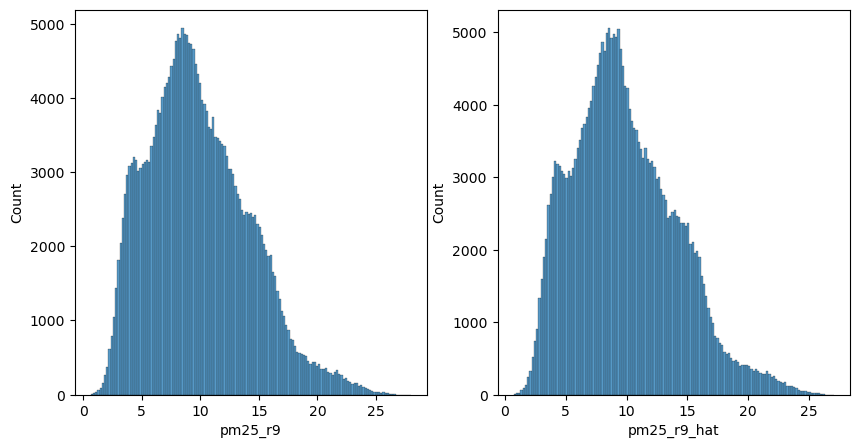

In [39]:
columns = [target_name_s1, target_name_s1+'_hat']

# compute visits by patzip_year_month
fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(10, 5))

for idx, ax in enumerate(axes.flatten()):
    sns.histplot(
            df_model_s1[columns[idx]],
            ax=ax
        )

# Cross validation function



In [48]:
def time_series_cv(
  df: pd.DataFrame, 
  xvars: list, 
  yvar: str, 
  hyperparams: dict = {'max_depth': [1, 5, 10], 'subsample': [.8, 1], 'eta': [.1, .3]}, 
  search_type='grid', 
  folds=5, 
  verbose=1):

  ''' 
  Inputs:
  - df: dataframe of your training data
  - xvars: a list of all the xvars to pass to xgboost
  - yvar: string of your target variable
  - verbose: optionality for diff amounts of printouts. Can be 0, 1, 2. 0 = silent, 1 = update after each fold, 2 = update after every single hyperparam combination. 
  - hyperparams: this must be a dictionary of lists. So each key is a xgb hyperparam, then it must have a list of values to tune with. 
    See the default for an example. Can put in an arbitrary number of hyperparam options. 
  
  Output:
  - dictionary with the following keys: ['fold', 'hyperparams', 'rmse_train', 'rmse_test']. 
  '''

  # this dictionary will hold all the final results
  final_res = {'fold':[], 'hyperparams':[], 'rmse_train': [], 'rmse_test': [],
                'huber_loss_train': [], 'huber_loss_test': []}

  # get only necessary fields in df
  df = df[xvars + [yvar]]

  # set up the time series split class, to do an expanding window cross fold. 
  tss = TimeSeriesSplit(n_splits=folds)
  tss_folds = tss.split(df)
  all_folds = [i for i in tss_folds]

  # get all combinations of hyperparams
  def expand_grid(hyperparams):
    keys = list(hyperparams.keys())
    hyperparams_df = pd.DataFrame(np.array(np.meshgrid(*[hyperparams[key_i] for key_i in keys])).T.reshape(-1, len(keys)))
    hyperparams_df.columns = keys 
    return hyperparams_df

  df_hyperparams = expand_grid(hyperparams)

  # function to use later
  def get_rmse(dmat_train, df_train):
    ytrue = df_train[yvar].values.flatten()
    yhat = booster.predict(dmat_train)
    rmse = np.mean(((ytrue - yhat)**2)**.5)
    return rmse 
  
  def get_huber_loss(dmat_train, df_train):
    # # Let the delta for Huber Loss be 2*standard deviation of non-zero entries for the y variable
    # twice_std = 2 * df_train[df_train[yvar] > 0][yvar].std  

    # Let the delta for Huber Loss be 2*standard deviation of the y variable
    twice_std = 2 * df_train[yvar].std() 

    def huber_loss(y_actual,y_predicted,delta):
      # https://towardsdatascience.com/understanding-loss-functions-the-smart-way-904266e9393
      # approaches MSE for small error an approaches MAE in case of outliers.
      delta = 5
      total_points = y_actual.size
      total_error = 0
      for i in range(total_points):
        error = np.absolute(y_predicted[i] - y_actual[i])
        if error < delta:
          huber_error = (error*error)/2
        else:
          huber_error = delta*(error - (0.5*delta))
        total_error+=huber_error
      total_huber_error = total_error/total_points
      return total_huber_error  # mean huber_loss

    ytrue = df_train[yvar].values.flatten()
    yhat = booster.predict(dmat_train)

    huber_loss_val = huber_loss(y_actual=ytrue, y_predicted=yhat, delta=twice_std)

    return huber_loss_val

  # loop over each expanding time series window
  for fold_count,fold in enumerate(all_folds):
    if verbose > 0:
      print('Working on fold {}/{}'.format(fold_count+1, folds))

    df_train = df.loc[fold[0]]
    df_test = df.loc[fold[1]]

    # convert to xgb types
    dmat_train = xgb.DMatrix(df_train[xvars], df_train[yvar])
    dmat_test = xgb.DMatrix(df_test[xvars], df_test[yvar])

    # within each time series cross fold, perform a grid search with all hyperparam combinations and evaluate results. 
    if search_type == 'grid':
      for param_set_i in range(df_hyperparams.shape[0]):
        hyperparams_i = {x:y for x,y in zip(df_hyperparams.columns, df_hyperparams.loc[param_set_i].to_list())}
        
        # fix datatype for some vars
        if 'max_depth' in hyperparams_i.keys():
          hyperparams_i['max_depth'] = int(hyperparams_i['max_depth'])

        # fit xgb
        booster = xgb.train(
          hyperparams_i,
          dmat_train,
          num_boost_round=180, 
          early_stopping_rounds=15,
          evals = [(dmat_train, 'train'), (dmat_test, 'test')], 
          verbose_eval=False)
        
        # save results
        rmse_train = get_rmse(dmat_train, df_train)
        rmse_test = get_rmse(dmat_test, df_test)
        huber_train = get_huber_loss(dmat_train, df_train)
        huber_test = get_huber_loss(dmat_test, df_test)
        final_res['fold'].append(fold_count)
        final_res['hyperparams'].append(hyperparams_i)
        final_res['rmse_train'].append(rmse_train)
        final_res['rmse_test'].append(rmse_test)
        final_res['huber_loss_train'].append(huber_train)
        final_res['huber_loss_test'].append(huber_test)

        if verbose == 2:
          print('{}: rmse train: {:.3f}, rmse test: {:.3f}'.format(hyperparams_i, rmse_train, rmse_test))

    elif search_type == 'random': 
      pass 
      # haven't done this yet
  
  # print out final best hyperparams before returning the output
  output2 = pd.DataFrame({
    'hyperparams': final_res['hyperparams'],
    'fold': final_res['fold'],
    'rmse_train': final_res['rmse_train'],
    'rmse_test': final_res['rmse_test']
  })
  output2['hyperparams'] = output2['hyperparams'].astype(str)
  output2 = output2.groupby('hyperparams')[['rmse_train', 'rmse_test']].mean().reset_index().sort_values('rmse_test')
  print('best hyperparams: {}'.format(output2.iloc[0,0]))
  print(f"best RMSE test: {output2.iloc[0]['rmse_test']}")

  best_hyperparams = output2.iloc[0,0]

  
  return final_res, eval(best_hyperparams)
  

In [49]:
print(y_var_s2)

y_hematopoietic_fwd3


In [50]:
predictor_name_s2 = target_name_s1 + "_hat"

df_model_s2 = df_model_s1.dropna(subset=([y_var_s2, predictor_name_s2] + fixed_effects_cols))
df_model_s2 = df_model_s2.sort_values('year_month').reset_index(drop=True)

print(f"Size of 2nd stage df before filtering for modeling: {df_model_s1.shape}")
print(f"Size of 2nd stage df after filtering for modeling: {df_model_s2.shape}")

Size of 2nd stage df before filtering for modeling: (262450, 306)
Size of 2nd stage df after filtering for modeling: (66151, 306)


In [51]:
# number of 0 entries
df_model_s2[df_model_s2[y_var_s2] == 0].shape

(41573, 306)

In [52]:
print(min(df_model_s2.year_month))
print(max(df_model_s2.year_month))

2002-01-01 00:00:00
2017-10-01 00:00:00


<AxesSubplot: >

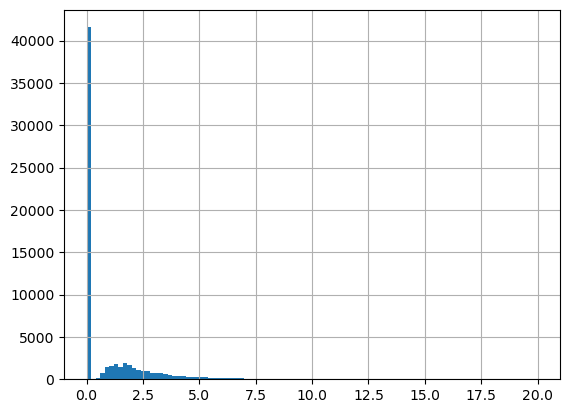

In [53]:
df_model_s2[y_var_s2].hist(bins=100, range=(0,20))

In [54]:
output, best_hyperparams_s2 = time_series_cv(df_model_s2, xvars = ([predictor_name_s2] + fixed_effects_cols), yvar = y_var_s2, 
  hyperparams = {'max_depth': [3, 5, 10, 14, 18], 'subsample': [.5, .8, 1], 'eta': [0.01, 0.05, 0.08, .1, .3], 'lambda': [1, .8, 0.5, 0.3, 0.1]}, 
  search_type = 'grid', 
  folds = 5, 
  verbose=1)

Working on fold 1/5
Working on fold 2/5
Working on fold 3/5
Working on fold 4/5
Working on fold 5/5
best hyperparams: {'max_depth': 18, 'subsample': 1.0, 'eta': 0.01, 'lambda': 1.0}
best RMSE test: 2.0572965489113013


In [61]:
best_hyperparams_s2

"{'max_depth': 18, 'subsample': 1.0, 'eta': 0.01, 'lambda': 1.0}"

In [64]:
t = eval(best_hyperparams_s2)
print(type(t))
t

<class 'dict'>


{'max_depth': 18, 'subsample': 1.0, 'eta': 0.01, 'lambda': 1.0}

In [55]:
stage2_params_best = {'max_depth': 18, 'subsample': 1.0, 'eta': 0.01, 'lambda': 1.0, 'n_estimators': 180}
X = df_model_s2[[predictor_name_s2] + fixed_effects_cols]
y = df_model_s2[y_var_s2]

xgbr_s2_best = xgb.XGBRegressor(**stage2_params_best, random_state=20)
xgbr_s2_best.fit(X, y)
y_hat_s2 = xgbr_s2_best.predict(X)

rmse_val = np.mean(((y - y_hat_s2)**2)**.5)
print(rmse_val)

1.4276485622941064


Save out the stage 2 XGBRegressor

In [56]:
df_model_s2[y_var_s2+'_hat'] = y_hat_s2

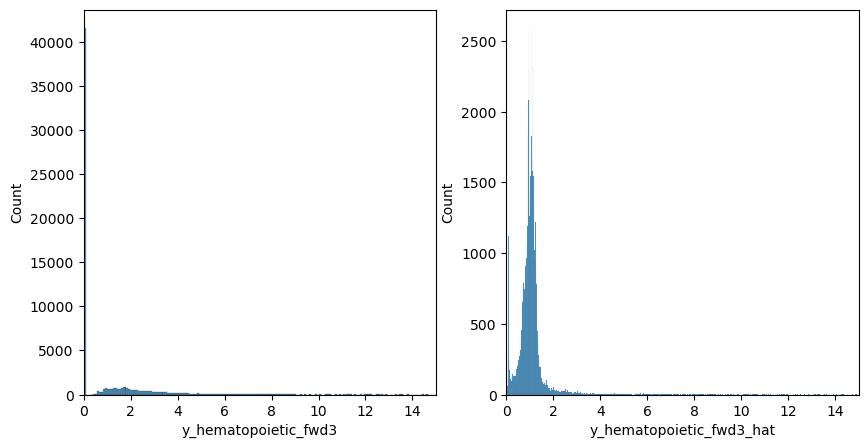

In [57]:
columns = [y_var_s2, y_var_s2+'_hat']

# compute visits by patzip_year_month
fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(10, 5))

for idx, ax in enumerate(axes.flatten()):
    ax.set_xlim(0, 15)

    sns.histplot(
            df_model_s2[columns[idx]],
            ax=ax
        )

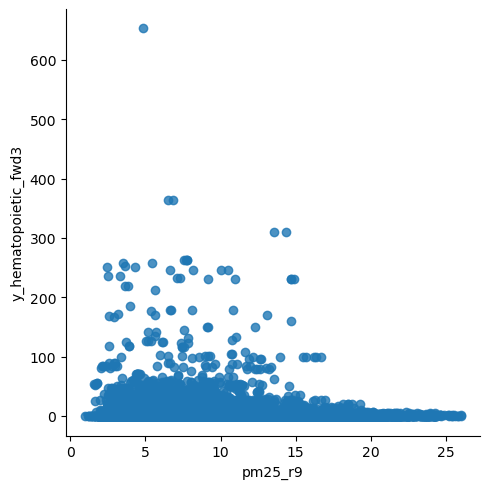

In [112]:
sns.lmplot(x = target_name_s1, y = y_var_s2, data = df_model_s2)


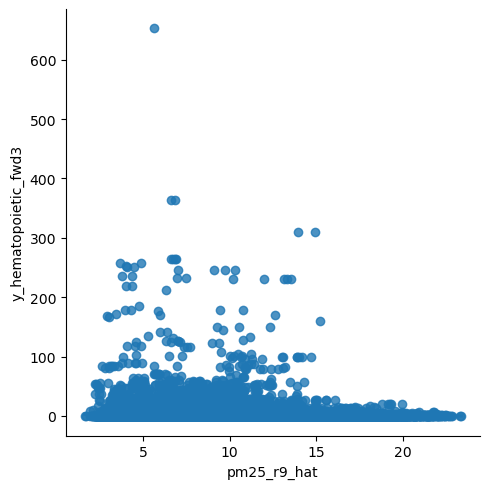

In [115]:
sns.lmplot(x = predictor_name_s2, y = y_var_s2, data = df_model_s2)


In [98]:
output, best_hyperparams_s2 = time_series_cv(df_model_s2, xvars = ([target_name_s1] + fixed_effects_cols), yvar = y_var_s2, 
  hyperparams = {'max_depth': [3, 5, 10, 18], 'subsample': [.8, 1], 'eta': [.1, .3], 'lambda': [1, .8]}, 
  search_type = 'grid', 
  folds = 5, 
  verbose=1)

Working on fold 1/5
Working on fold 2/5
Working on fold 3/5
Working on fold 4/5
Working on fold 5/5
best hyperparams: {'max_depth': 3, 'subsample': 1.0, 'eta': 0.1, 'lambda': 1.0}
best RMSE test: 2.344592150551608


In [99]:
best_hyperparams_s2

"{'max_depth': 3, 'subsample': 1.0, 'eta': 0.1, 'lambda': 1.0}"

## Optional

Organize the results manually. But I put this in the function to spit the best result at the end anyways. 

But this shows how you can manipulate and inspect the results.

In [58]:
output2 = pd.DataFrame({
  'hyperparams': output['hyperparams'],
  'fold': output['fold'],
  'rmse_train': output['rmse_train'],
  'rmse_test': output['rmse_test'],
  'huber_loss_train': output['huber_loss_train'],
  'huber_loss_test': output['huber_loss_test']
})
output2

,hyperparams,fold,rmse_train,rmse_test,huber_loss_train,huber_loss_test
0,"{'max_depth': 3, 'subsample': 0.5, 'eta': 0.01...",0,1.612499,1.774722,3.479373,4.187349
1,"{'max_depth': 3, 'subsample': 0.8, 'eta': 0.01...",0,1.594170,1.759879,3.470421,4.195747
2,"{'max_depth': 3, 'subsample': 1.0, 'eta': 0.01...",0,1.576300,1.720346,3.506850,4.144289
3,"{'max_depth': 5, 'subsample': 0.5, 'eta': 0.01...",0,1.565868,1.739629,3.451092,4.218637
4,"{'max_depth': 5, 'subsample': 0.8, 'eta': 0.01...",0,1.557699,1.722183,3.494861,4.232484
...,...,...,...,...,...,...
1870,"{'max_depth': 14, 'subsample': 0.8, 'eta': 0.3...",4,1.227140,3.946100,1.692541,13.778310
1871,"{'max_depth': 14, 'subsample': 1.0, 'eta': 0.3...",4,1.071356,3.917623,1.273341,13.851243
1872,"{'max_depth': 18, 'subsample': 0.5, 'eta': 0.3...",4,1.294911,4.806422,2.013675,17.133279
1873,"{'max_depth': 18, 'subsample': 0.8, 'eta': 0.3...",4,0.900587,4.202704,0.953298,15.012070


In [59]:
output2['hyperparams'] = output2['hyperparams'].astype(str)

output_grp = output2.groupby('hyperparams')[['rmse_train', 'rmse_test', \
'huber_loss_train', 'huber_loss_test']].mean().reset_index().sort_values('rmse_test')

output_grp

,hyperparams,rmse_train,rmse_test,huber_loss_train,huber_loss_test
204,"{'max_depth': 18, 'subsample': 1.0, 'eta': 0.0...",1.505435,2.057297,3.391462,5.602434
129,"{'max_depth': 14, 'subsample': 1.0, 'eta': 0.0...",1.556087,2.057887,3.505925,5.572220
128,"{'max_depth': 14, 'subsample': 1.0, 'eta': 0.0...",1.557085,2.059496,3.517080,5.585046
203,"{'max_depth': 18, 'subsample': 1.0, 'eta': 0.0...",1.508351,2.061064,3.405519,5.624965
54,"{'max_depth': 10, 'subsample': 1.0, 'eta': 0.0...",1.620910,2.065368,3.654001,5.501820
...,...,...,...,...,...
97,"{'max_depth': 14, 'subsample': 0.5, 'eta': 0.3...",1.220751,3.229145,1.862123,10.287118
195,"{'max_depth': 18, 'subsample': 0.8, 'eta': 0.3...",0.673082,3.229531,0.563978,10.601586
171,"{'max_depth': 18, 'subsample': 0.5, 'eta': 0.3...",1.014177,3.352401,1.362081,10.727738
95,"{'max_depth': 14, 'subsample': 0.5, 'eta': 0.3...",1.218425,3.448840,1.824647,11.364192


In [60]:
print('best hyperparams: {}'.format(output_grp.iloc[0,0]))

best hyperparams: {'max_depth': 18, 'subsample': 1.0, 'eta': 0.01, 'lambda': 1.0}
